# **Instalação do Hugging face**
Biblioteca usada


In [ ]:
!pip install huggingface_hub -t


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-t option requires 1 argument


# **Criação do API KEY**
Usada como chave de acesso

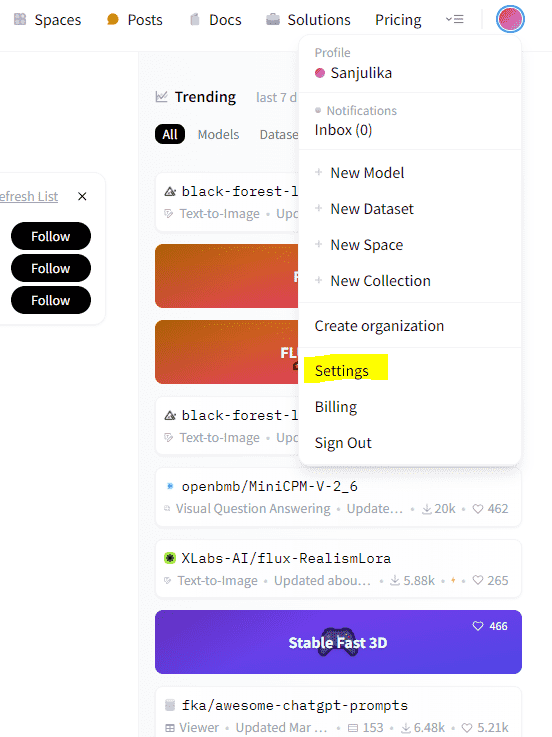

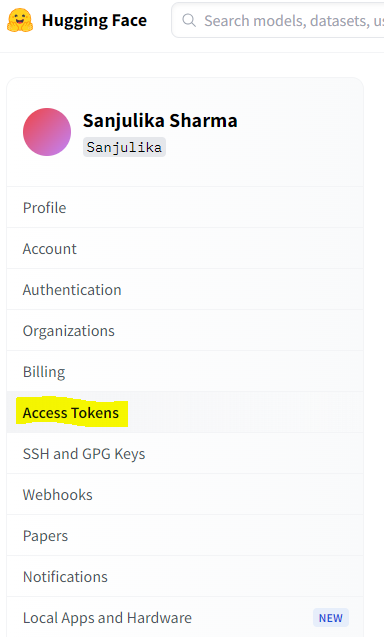

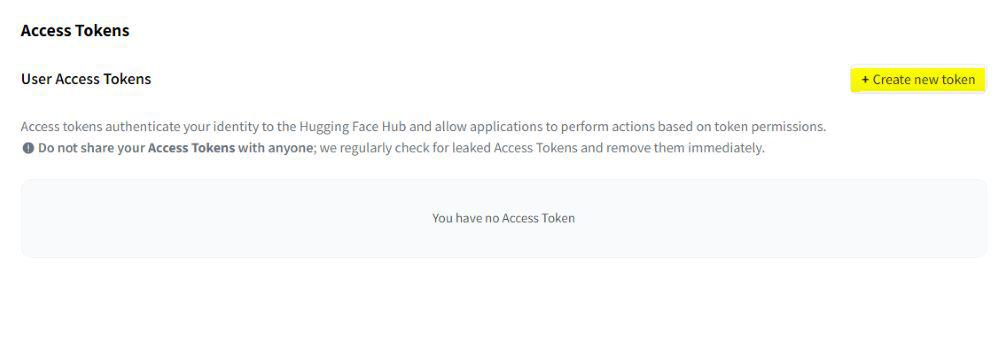

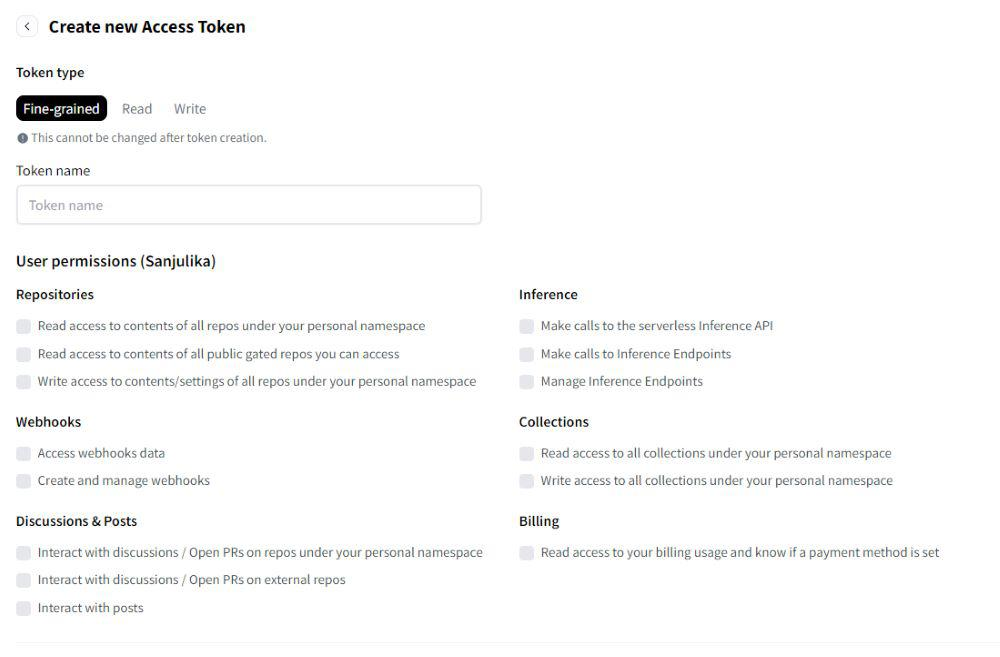

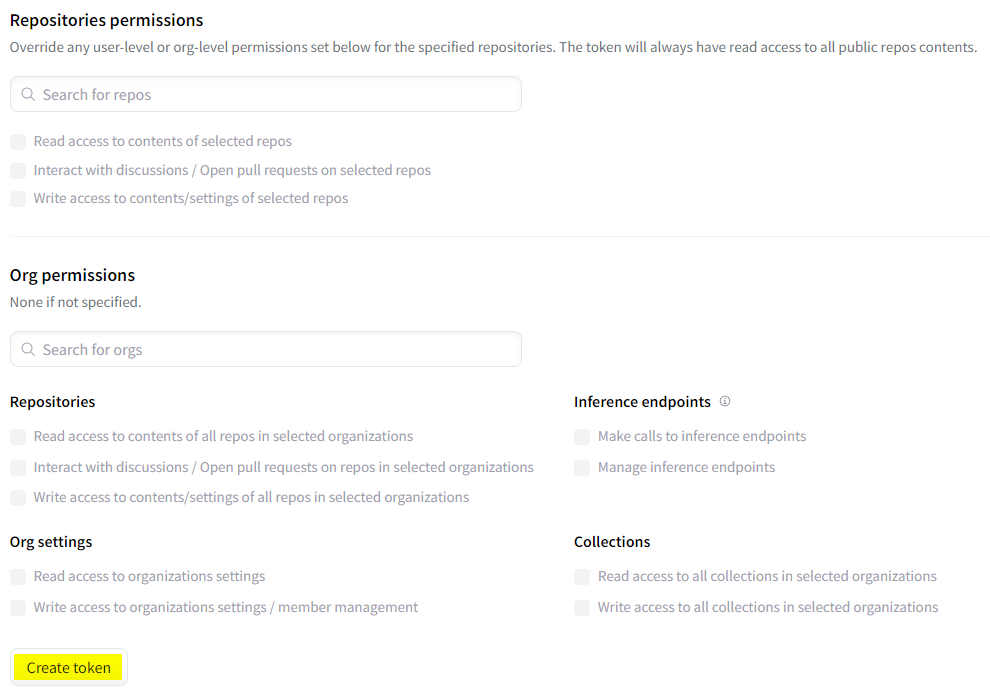

In [ ]:
apiKey = ""
#inserir chave aqui



---



# **Importação das bibliotecas e implementação do código**
treinamento e extração do modelo JSON


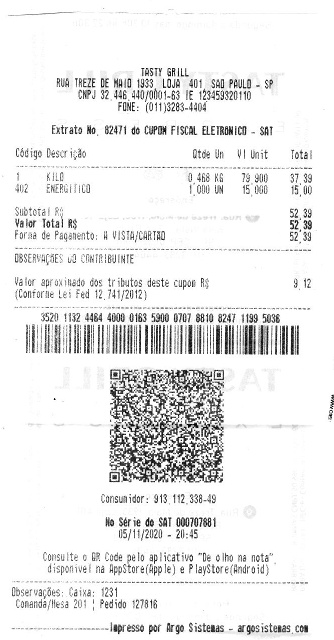

In [9]:
%%time
# Importando as bibliotecas necessárias
import urllib3
import json
import re
import time

start_time = time.time()

# Função para extrair JSON da resposta
def extrair_json_da_resposta(response_text):
    try:
        return json.loads(response_text)  # Tentando converter diretamente o texto da resposta em JSON
    except json.JSONDecodeError as e:
        print("Erro ao decodificar JSON:", e)
        return None

# Configurações
url = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3/v1/chat/completions"  # TODO: Mover para .env

# Configuração do prompt
prompt = f"""Instruction:
    You are a specialized receipt data expert focused on the financial sector. Your task is to analyze, detect, recognize, and extract key financial data from the OCR text of a receipt image, converting it into a strictly formatted JSON object. Extract ONLY data that is explicitly present in the input—no assumptions, inventions, or additional fields are allowed.

    The JSON response MUST contain EXACTLY these fields, no more, no less:
        *nome_emissor*: string | 'None',
        *CNPJ_emissor*: string | 'None',
        *endereco_emissor*: string | 'None',
        *CNPJ_CPF_consumidor*: string | 'None',
        *data_emissao*: string | 'None',
        *numero*: string | 'None',
        *serie_nota_fiscal*: string | 'None',
        *valor_total*: string | 'None',
        *forma_pgto*: string | 'None'

    Strict field requirements and examples:
    1. nome_emissor:
       - Company name only
       - NEVER include: *consumidor*, *cliente*, *comprador*
       - Example valid: *Supermercado Silva Ltda*
       - Example invalid: *Nome do Consumidor: João Silva*

    2. CNPJ_emissor:
       - Must be formatted as *00.000.000/0000-00*
       - Extract exactly 14 digits, ensuring *0001* represents the main branch
       - Example valid: *12.345.678/0001-90*
       - Example invalid: *12345678* (incomplete)

    3. endereco_emissor:
       - Must typically start with: *RUA*, *R*, *ROD*, *VL*
       - Extract ONLY the first address found
       - Exclude ANY instances of:
         * Receipt-related: *cupom fiscal*, *cupom*, *R$*, *extrato*
         * Financial terms: *Valor total*, *Nota fiscal*
         * Product-related: *Descrição*, *Qtd*, *valor*
         * Document terms: *Documento auxiliar*, *Dacusento Auxiliar da Nota Fiscal de*
         * Any variation of *Documento Auxiliar* or similar terms
       - Example valid: *Rua das Flores, 123 - Centro*
       - Example invalid: *Documento Auxiliar Rua das Flores*

    4. CNPJ_CPF_consumidor:
       - Look for identifiers near terms like *CPF/CNPJ* or *CONSUMIDOR*
       - Format: *xxx.xxx.xxx-xx*
       - Return null if not present
       - Example valid: *123.456.789-00*
       - Example invalid: *12345678* (incomplete)

    5. data_emissao:
       - Accept only: DD/MM/YYYY, DD/MM/YY, DD-MM-YYYY, DD-MM-YY
       - Example valid: *15/03/2024*
       - Example invalid: *2024/03/15*

    6. numero_nota_fiscal:
       - Look for identifiers starting with: *Numero*, *No*, *No.*
       - Must be a numeric identifier that is NOT the total amount
       - Example valid: *No. 123456*
       - Example invalid: *150.90* (monetary value)

    7. serie_nota_fiscal:
       - Extract series information if present, otherwise null
       - Example valid: *Serie 001*
       - Example invalid: *S-001* (incorrect format)

    8. valor_total:
       - Must be in format *XXX.XX* (exactly two decimal places)
       - Must be greater than 10.00 (minimum valid total)
       - Look for values near terms like *TOTAL* or *valor pago*
       - Ignore values with more than two decimal places
       - Must be the highest valid monetary amount in the receipt
       - Example valid: *150.90*, *1234.56*
       - Example invalid: *2.21* (too low), *150.903* (too many decimals)

    9. forma_pgto: STRICTLY one of these three values:
       - *Pix* (if Pix payment is mentioned)
       - *Dinheiro* (if cash payment is mentioned)
       - *outros* (for ANY other payment method including credit, debit, card, or if no method is found)
       - Example invalid: *Consumidor*,*Via* (incorrect)

    OCR Error Handling:
    - Ignore common OCR artifacts like random symbols or unreadable characters
    - For addresses, merge words that may have been split due to OCR errors
    - For monetary values, ensure decimal points are correctly interpreted
    - For CNPJ/CPF, ignore spaces or special characters that may have been incorrectly inserted
    - When multiple addresses appear, use only the first valid address found

    Input:
    TASTY GRILL\nCNPJ: 32.446.440/0001-63\nRUA TREZE DE MAIO 1933 LOJA 401 SAO PAULO - SP\nTelefone: (011) 3283-4404\nCUPOM FISCAL ELETRÔNICO - SAT\nCódigo Descrição Qtde Un Vlr Unit\n401 KILO 1.486 Kg 37,39\n402 ENERGÉTICO 1.000 Un 15,00\nSubtotal R$ 52,39\nValor Total R$ 52,39\nForma de Pagamento: A VISTA/CARTAO\nConsumidor: 913.112.338-49\nNo Série de SAT 000707881\nEmitido em 11/11/2020 21:45

    Output:
    Return ONLY a JSON object with the exact structure above. No additional fields or explanations"""

# Configuração dos headers e dados
headers = {
    "Authorization": f"Bearer {apiKey}",
    "Content-Type": "application/json"
}

data = {
    "model": "mistralai/Mistral-7B-Instruct-v0.3",  # TODO: Mover para .env
    "messages": [
        {"role": "user", "content": prompt}
    ],
    "temperature": 0.1,  # TODO: Mover para .env
    "max_tokens": 1024,  # TODO: Mover para .env
    "top_p": 0.7  # TODO: Mover para .env
}

# Inicializando o urllib3
http = urllib3.PoolManager()

try:
    # Enviando a requisição para a API
    response = http.request(
        'POST',
        url,
        headers=headers,
        body=json.dumps(data).encode('utf-8')
    )

    if response.status == 200:
        response_content = response.data.decode('utf-8')
        response_json = json.loads(response_content)

        # Verificar a estrutura da resposta e se 'choices' e 'message' existem
        if "choices" in response_json and "message" in response_json["choices"][0]:
            resposta = response_json["choices"][0]["message"]["content"]
            resposta_json = extrair_json_da_resposta(resposta)

            if resposta_json:
                print(json.dumps(resposta_json, indent=2, ensure_ascii=False))
            else:
                print("JSON não encontrado na resposta.")
        else:
            print("Estrutura inesperada na resposta da API. Verifique o retorno.")
    else:
        print(f"Erro: {response.status} - {response.data.decode('utf-8')}")

except Exception as e:
    print(f"Erro ao processar requisição: {str(e)}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")


{
  "nome_emissor": "TASTY GRILL",
  "CNPJ_emissor": "32.446.440/0001-63",
  "endereco_emissor": "RUA TREZE DE MAIO 1933 LOJA 401 SAO PAULO - SP",
  "CNPJ_CPF_consumidor": "913.112.338-49",
  "data_emissao": "11/11/2020",
  "numero": "No Série de SAT 000707881",
  "serie_nota_fiscal": "000707881",
  "valor_total": "52.39",
  "forma_pgto": "outros"
}
Tempo de execução: 0.5688962936401367 segundos
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 569 ms
